In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'landscape')
pth_ref = os.path.join(pth_data, 'refs', 'AnimalTFDBv4')
pth_out = os.path.join(pth, 'figures', 'modeling', 'regulation')

In [3]:
# load & select data
fn = os.path.join(pth_in, 'development.h5ad')
adata = sc.read_h5ad(fn)
msk = (adata.obs.landscape == 'True') & \
      (adata.obs.source != 'rRNAModifications')
adata = adata[msk].copy(); adata

AnnData object with n_obs × n_vars = 11827 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z', 'Early', 'Late', 'X_mesen1', '

In [4]:
# transcription factors
fn = os.path.join(pth_ref, 'Mus_musculus_TF')
tf = pd.read_csv(fn, sep = '\t').Symbol
tf = tf.loc[tf.isin(adata.var_names)].values

In [5]:
c = {'GSE162534' : 'gold',
     'GSE229103' : 'tab:cyan'}

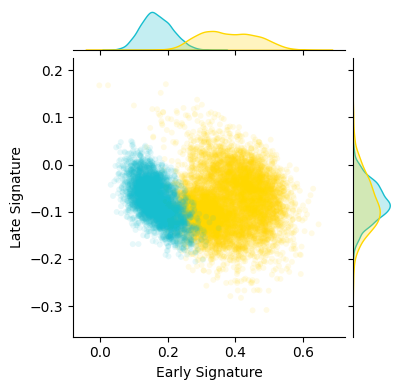

In [6]:
# plot signatures
margins = {'common_norm' : False}
sns.jointplot(data = adata.obs,
              x = 'Early',
              y = 'Late',
              hue = 'source',
              height = 4,
              ratio = 6,
              palette = c,
              size = 80,
              alpha = .1,
              linewidth = 0,
              marginal_kws = margins)

plt.xlabel('Early Signature')
plt.ylabel('Late Signature')
plt.legend().set_visible(False)
fn = os.path.join(pth_out, 'signatures.pdf')
plt.savefig(fn, bbox_inches = 'tight')

In [7]:
# balanced sample
n = adata.obs.source.value_counts().min()
ix = (adata.obs.groupby('source', observed = True)
      .sample(n = n, random_state = 1).index)
adata_sample = adata[ix].copy(); adata_sample

AnnData object with n_obs × n_vars = 8514 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z', 'Early', 'Late', 'X_mesen1', 'X

In [8]:
# X (features): TF expression, source
src = adata_sample.obs.source.copy()
X = adata_sample[:, tf].X.toarray()
X = StandardScaler().fit_transform(X)
src = pd.get_dummies(src).values.astype(float)
X = np.concatenate((X, src), axis = 1)

# y (targets): early signature
y = adata_sample.obs.Early.values.reshape(-1, 1)
y = StandardScaler().fit_transform(y).flatten()

# linear regression (y ~ X)
reg = LinearRegression(fit_intercept = False).fit(X, y)

# TF coefficients (beta)
beta = pd.Series(reg.coef_[:-src.shape[1]], index = tf)
beta = beta.sort_values(ascending = False); beta

Pou5f1    0.193051
T         0.112734
Mesp1     0.099846
Cdx4      0.093384
Sp5       0.072546
            ...   
Osr1     -0.022344
Hmga1    -0.025105
Alx1     -0.027739
Sub1     -0.034053
Ybx1     -0.063506
Length: 141, dtype: float64

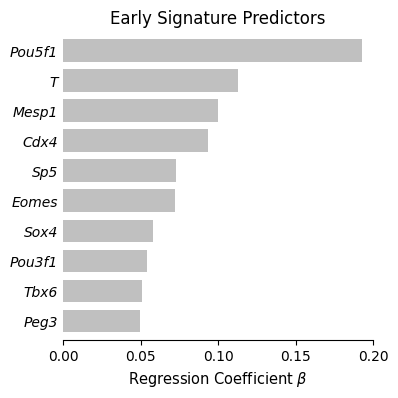

In [13]:
# plot top predictors
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
beta.head(10).plot(kind = 'barh', width = .75,
                   color = 'silver', ax = ax)

ax.set_xlim(0, .2)
ax.set_xlabel(r'Regression Coefficient $\beta$', size = 10.5)

ax.tick_params('y', size = 0)
for lbl in ax.get_yticklabels():
    lbl.set_fontstyle('italic')

ax.set_title('Early Signature Predictors', size = 12)

for sp in ('top', 'right', 'left'):
    ax.spines[sp].set_visible(False)

ax.invert_yaxis()
fn = os.path.join(pth_out, 'regression.pdf')
plt.savefig(fn, bbox_inches = 'tight')

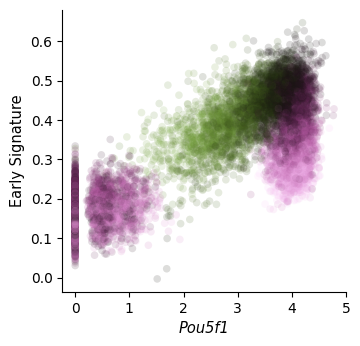

In [30]:
# plot pou5f1 vs. early signature
fig, ax = plt.subplots(1, 1, figsize = (3.66, 3.66))
ax.scatter(x = adata[:, 'Pou5f1'].X.toarray(),
           y = adata.obs.Early,
           c = adata.obs.latent_z,
           cmap = 'vanimo',
           vmin = 0, vmax = 1,
           s = 30, alpha = .15,
           linewidths = 0)

for sp in ('right', 'top'):
    ax.spines[sp].set_visible(False)

ax.set_xlim(right = 5)
ax.set_xlabel('Pou5f1', fontstyle = 'italic', size = 10.5)
ax.set_ylabel('Early Signature', size = 10.5)
fn = os.path.join(pth_out, 'Pou5f1.pdf')
plt.savefig(fn, bbox_inches = 'tight')